# LLM Inference & Evaluation with NVIDIA API

## Workshop: LLM Development from Scratch
### Duration: 60 minutes
### Platform: build.nvidia.com

---

In this notebook, you will:
1. Load ParamBench Hindi evaluation dataset
2. Connect to NVIDIA API (build.nvidia.com)
3. Test Llama 3 and other models
4. Evaluate model performance on Hindi questions
5. Compare different models

**build.nvidia.com** provides API access to state-of-the-art LLMs optimized on NVIDIA infrastructure.


## Section 1: Setup & Authentication (5 minutes)

Get your API key from [build.nvidia.com](https://build.nvidia.com)


In [ ]:
# Install required libraries
!pip install -q openai datasets pandas matplotlib tqdm


In [1]:
import os
from openai import OpenAI

# Set your NVIDIA API key
# Get it from: https://build.nvidia.com/
NVIDIA_API_KEY = "your-nvapi-key"  # Replace with your key

# Or set as environment variable: export NVIDIA_API_KEY='your_key'
if "nvapi-" not in NVIDIA_API_KEY or NVIDIA_API_KEY == "nvapi-YOUR_KEY_HERE":
    NVIDIA_API_KEY = os.getenv("NVIDIA_API_KEY", "")
    if not NVIDIA_API_KEY:
        print("⚠️  Please set your NVIDIA_API_KEY!")
        print("   Get it from: https://build.nvidia.com/")
    else:
        print("✅ API key loaded from environment")
else:
    print("✅ API key set")

# Initialize NVIDIA API client
client = OpenAI(
    base_url="https://integrate.api.nvidia.com/v1",
    api_key=NVIDIA_API_KEY
)

print("\n🔧 NVIDIA API client initialized!")
print("   Base URL: https://integrate.api.nvidia.com/v1")


✅ API key set

🔧 NVIDIA API client initialized!
   Base URL: https://integrate.api.nvidia.com/v1


## Section 2: Load ParamBench Dataset (5 minutes)

[ParamBench](https://huggingface.co/datasets/bharatgenai/ParamBench): 17K Hindi MCQ questions from Indian competitive exams
- 21 subjects (Anthropology, History, Law, Sanskrit, etc.)
- Graduate-level questions
- Perfect for evaluating Hindi language understanding


In [2]:
from datasets import load_dataset
import pandas as pd

print("📥 Loading ParamBench dataset from Hugging Face...")

# Load dataset
dataset = load_dataset("bharatgenai/ParamBench", split="test")

print(f"✅ Loaded {len(dataset):,} questions!")

# Convert to pandas
df = pd.DataFrame(dataset)

# Show statistics
print(f"\n📊 Dataset Statistics:")
print(f"   Total questions: {len(df):,}")
print(f"   Subjects: {df['subject'].nunique()}")
print(f"   Question types: {df['question_type'].nunique()}")

# Top subjects
print(f"\n📚 Top 10 Subjects:")
for subject, count in df['subject'].value_counts().head(10).items():
    print(f"   {subject}: {count}")


/opt/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📥 Loading ParamBench dataset from Hugging Face...


Generating test split: 100%|██████████| 17275/17275 [00:00<00:00, 608955.76 examples/s]


✅ Loaded 17,275 questions!

📊 Dataset Statistics:
   Total questions: 17,275
   Subjects: 21
   Question types: 6

📚 Top 10 Subjects:
   Education: 1199
   Sociology: 1191
   Anthropology: 1139
   Psychology: 1102
   Archaeology: 1076
   History: 996
   Comparative Study of Religions: 954
   Law: 951
   Indian Culture: 927
   Economics: 919


In [3]:
# Show sample question
sample = df.iloc[0]

print("📝 Sample Question:\n")
print("=" * 80)
print(f"Subject: {sample['subject']}")
print(f"Type: {sample['question_type']}")
print(f"\nQ: {sample['question_text']}")
print(f"\nOptions:")
print(f"  A) {sample['option_a']}")
print(f"  B) {sample['option_b']}")
print(f"  C) {sample['option_c']}")
print(f"  D) {sample['option_d']}")
print(f"\n✅ Correct Answer: {sample['correct_answer']}")
print("=" * 80)


📝 Sample Question:

Subject: Anthropology
Type: Normal MCQ

Q: भारतीय मध्य पाषाणकाल निम्नलिखित में से किस स्थान पर सर्वोत्तम प्रदर्शित है ?

Options:
  A) गिद्दालूर
  B) नेवासा
  C) टेरी समूह
  D) बागोर

✅ Correct Answer: D


## Section 3: Test NVIDIA API Models (10 minutes)

Available models on build.nvidia.com:
- `meta/llama-3.1-8b-instruct`
- `meta/llama-3.1-70b-instruct` 
- `mistralai/mistral-7b-instruct-v0.3`
- And many more!


In [4]:
def test_model_on_question(client, model_name, question_row):
    """Test a model on a single ParamBench question"""
    
    # Format prompt in Hindi
    prompt = f"""निम्नलिखित प्रश्न का उत्तर दें। केवल विकल्प (A, B, C, या D) लिखें।

प्रश्न: {question_row['question_text']}

विकल्प:
A) {question_row['option_a']}
B) {question_row['option_b']}
C) {question_row['option_c']}
D) {question_row['option_d']}

उत्तर:"""
    
    try:
        # Call NVIDIA API
        response = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,  # Greedy decoding for consistency
            max_tokens=10,
        )
        
        # Extract answer
        answer = response.choices[0].message.content.strip()
        
        # Extract letter (A, B, C, or D)
        for letter in ['A', 'B', 'C', 'D']:
            if letter in answer.upper():
                return letter
        
        return answer[:1].upper()  # Fallback
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Test on sample question
print("🧪 Testing Llama 3.1-8B on sample question...\n")

test_q = df.iloc[0]
model = "meta/llama-3.1-8b-instruct"

prediction = test_model_on_question(client, model, test_q)
correct = test_q['correct_answer']

print(f"Question: {test_q['question_text'][:100]}...")
print(f"\nModel prediction: {prediction}")
print(f"Correct answer: {correct}")
print(f"Result: {'✅ Correct!' if prediction == correct else '❌ Wrong'}")


🧪 Testing Llama 3.1-8B on sample question...

Question: भारतीय मध्य पाषाणकाल निम्नलिखित में से किस स्थान पर सर्वोत्तम प्रदर्शित है ?...

Model prediction: A
Correct answer: D
Result: ❌ Wrong


## Section 4: Batch Evaluation (20 minutes)

Evaluate models on a subset of ParamBench questions.

**Note**: Using 100 questions (sampled from 17K) to complete within workshop time.


In [5]:
import time
from tqdm import tqdm

def evaluate_model(client, model_name, questions_df, max_questions=100):
    """Evaluate a model on ParamBench questions"""
    
    print(f"\n🔍 Evaluating {model_name}...")
    print(f"   Testing on {min(max_questions, len(questions_df))} questions")
    
    # Sample questions
    sample_df = questions_df.sample(n=min(max_questions, len(questions_df)), random_state=42)
    
    results = []
    correct_count = 0
    
    for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Evaluating"):
        prediction = test_model_on_question(client, model_name, row)
        is_correct = (prediction == row['correct_answer'])
        
        if is_correct:
            correct_count += 1
        
        results.append({
            'question_id': row['unique_question_id'],
            'subject': row['subject'],
            'prediction': prediction,
            'correct_answer': row['correct_answer'],
            'is_correct': is_correct
        })
        
        # Rate limiting
        time.sleep(0.5)
    
    accuracy = correct_count / len(results) * 100
    
    print(f"\n✅ Evaluation complete!")
    print(f"   Accuracy: {accuracy:.2f}% ({correct_count}/{len(results)})")
    
    return pd.DataFrame(results), accuracy

# Evaluate Llama 3.1-8B on 100 questions
results_llama3, acc_llama3 = evaluate_model(
    client,
    "meta/llama-3.1-8b-instruct",
    df,
    max_questions=10
)



🔍 Evaluating meta/llama-3.1-8b-instruct...
   Testing on 10 questions


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


✅ Evaluation complete!
   Accuracy: 30.00% (3/10)


## Section 5: Subject-wise Analysis (10 minutes)

Analyze model performance across different subjects.


📊 Subject-wise Performance:

   Archaeology: 100.0% (1 questions)
   Comparative Study of Religions: 100.0% (1 questions)
   Education: 100.0% (1 questions)
   Economics: 0.0% (1 questions)
   History: 0.0% (2 questions)
   Indian Culture: 0.0% (1 questions)
   Law: 0.0% (1 questions)
   Music: 0.0% (1 questions)
   RABINDRA SANGEET: 0.0% (1 questions)


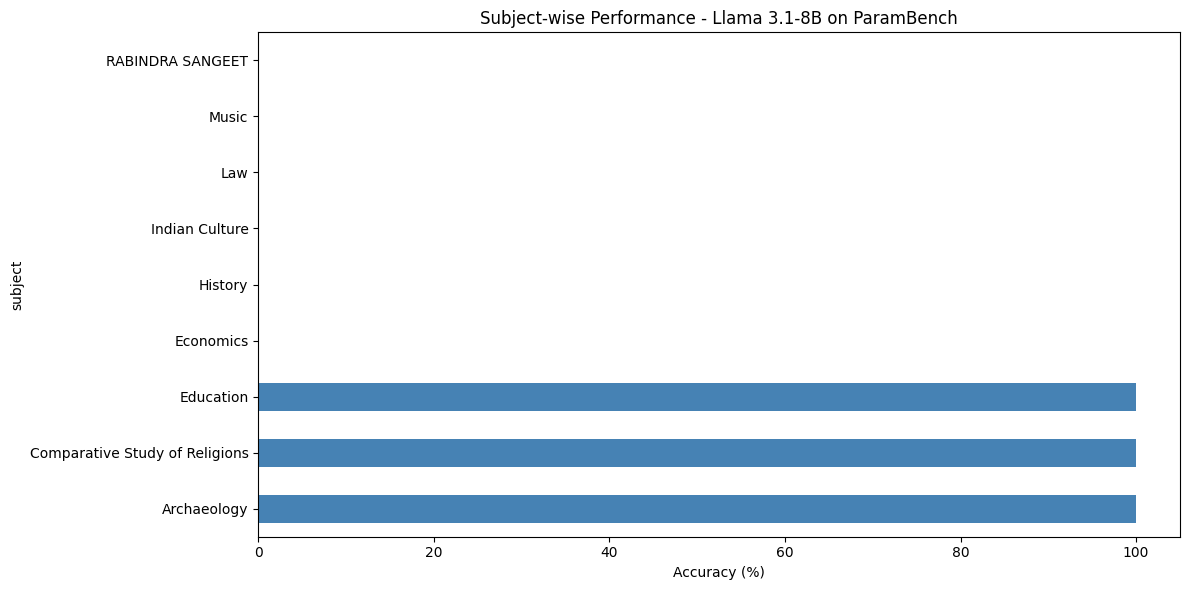

In [6]:
import matplotlib.pyplot as plt

# Calculate subject-wise accuracy
subject_accuracy = results_llama3.groupby('subject')['is_correct'].apply(
    lambda x: x.sum() / len(x) * 100
).sort_values(ascending=False)

print("📊 Subject-wise Performance:\n")
for subject, acc in subject_accuracy.items():
    count = (results_llama3['subject'] == subject).sum()
    print(f"   {subject}: {acc:.1f}% ({count} questions)")

# Visualize
plt.figure(figsize=(12, 6))
subject_accuracy.plot(kind='barh', color='steelblue')
plt.xlabel('Accuracy (%)')
plt.title('Subject-wise Performance - Llama 3.1-8B on ParamBench')
plt.tight_layout()
plt.show()


## Section 6: Compare Multiple Models (15 minutes)

Compare performance across different models from build.nvidia.com


In [7]:
# Models to compare
models_to_test = [
    "meta/llama-3.1-8b-instruct",
    "mistralai/mistral-7b-instruct-v0.3",
]

# Common test set for fair comparison
test_set = df.sample(n=100, random_state=42)

comparison_results = {}

for model in models_to_test:
    print(f"\n{'='*80}")
    print(f"Testing: {model}")
    print(f"{'='*80}")
    
    try:
        results, accuracy = evaluate_model(client, model, test_set, max_questions=100)
        comparison_results[model] = {
            'accuracy': accuracy,
            'results': results
        }
    except Exception as e:
        print(f"⚠️  Could not test {model}: {e}")
        continue

print(f"\n\n{'='*80}")
print("📊 MODEL COMPARISON")
print(f"{'='*80}")
for model, data in comparison_results.items():
    print(f"\n{model}")
    print(f"   Accuracy: {data['accuracy']:.2f}%")



Testing: meta/llama-3.1-8b-instruct

🔍 Evaluating meta/llama-3.1-8b-instruct...
   Testing on 100 questions


Evaluating: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]



✅ Evaluation complete!
   Accuracy: 46.00% (46/100)

Testing: mistralai/mistral-7b-instruct-v0.3

🔍 Evaluating mistralai/mistral-7b-instruct-v0.3...
   Testing on 100 questions


Evaluating: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


✅ Evaluation complete!
   Accuracy: 32.00% (32/100)


📊 MODEL COMPARISON

meta/llama-3.1-8b-instruct
   Accuracy: 46.00%

mistralai/mistral-7b-instruct-v0.3
   Accuracy: 32.00%


In [ ]:
# Visualize comparison
if comparison_results:
    model_names = list(comparison_results.keys())
    accuracies = [comparison_results[m]['accuracy'] for m in model_names]
    
    plt.figure(figsize=(10, 6))
    colors = ['steelblue', 'coral', 'lightgreen', 'gold']
    plt.bar(range(len(model_names)), accuracies, color=colors[:len(model_names)])
    plt.xticks(range(len(model_names)), [m.split('/')[-1] for m in model_names], rotation=45, ha='right')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Comparison on ParamBench (Hindi MCQs)')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


## Section 7: Interactive Testing (10 minutes)

Try different subjects or your own questions!


In [ ]:
# Filter by subject (change to any subject!)
subject_to_test = "History"

subject_questions = df[df['subject'] == subject_to_test].sample(n=5)

print(f"🎯 Testing on {subject_to_test} questions:\n")

model = "meta/llama-3.1-8b-instruct"
correct = 0

for idx, q in subject_questions.iterrows():
    print(f"\nQ: {q['question_text']}")
    print(f"A) {q['option_a']}")
    print(f"B) {q['option_b']}")
    print(f"C) {q['option_c']}")
    print(f"D) {q['option_d']}")
    
    pred = test_model_on_question(client, model, q)
    is_correct = (pred == q['correct_answer'])
    
    if is_correct:
        correct += 1
    
    print(f"\nModel: {pred} | Correct: {q['correct_answer']} | {'✅' if is_correct else '❌'}")
    print("-" * 80)

print(f"\n{subject_to_test} Accuracy: {correct/len(subject_questions)*100:.1f}%")


---

## 🎉 Congratulations!

You've successfully:
- ✅ Used NVIDIA's build.nvidia.com API for inference
- ✅ Evaluated LLMs on Hindi language understanding  
- ✅ Analyzed performance across subjects
- ✅ Compared multiple models
- ✅ Explored real-world evaluation workflows

### Key Takeaways

1. **API-based inference** is practical for production
2. **Evaluation is critical** for understanding model capabilities
3. **Subject-specific analysis** reveals strengths/weaknesses
4. **Hindi models** still have room for improvement on Indian content

### What's Next?

- Try more models from build.nvidia.com
- Evaluate on all 17K ParamBench questions
- Fine-tune models for specific subjects
- Deploy models with NVIDIA NIM

### Resources

- [build.nvidia.com](https://build.nvidia.com/)
- [ParamBench Dataset](https://huggingface.co/datasets/bharatgenai/ParamBench)
- [NVIDIA NIM](https://www.nvidia.com/en-us/ai/)
- Workshop: [github.com/ayushbits/llm-development](https://github.com/ayushbits/llm-development)
